In [ ]:
import pandas as pd
import numpy as np
import datetime
from collections import Counter

!pip install vaderSentiment praw fake_useragent cryptocompare
import praw
import requests
from fake_useragent import UserAgent
import time
import cryptocompare


#pre-processing
from nltk.corpus import stopwords
from NLP_functions import clean_str, pos_only

#EDA
from NLP_functions import get_top_n_words, find_top_bigrams

#topic modeling
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, NMF
from NLP_functions import display_topics, prob_df, topic_matrix, top_topics_df
from gensim import matutils, models

#sentiment analysis
from NLP_functions import get_sentiments

#plotting
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

Intialize Reddit API

In [ ]:
reddit = praw.Reddit(client_id='oCxykEUclueAuA', client_secret='M8wVQw3nFxMsXHLGxurnTtkN-Mdvtg', user_agent='Crypto')

#### Get top posts of all time

In [ ]:
import warnings
warnings.filterwarnings('ignore')
posts = []
ml_subreddit = reddit.subreddit('Cryptocurrency')

#loop through top 1000 posts of all time, get data in list and append to dataframe as new row
for post in list(ml_subreddit.top('all', limit=1000)):
    date = datetime.datetime.utcfromtimestamp(post.created_utc)
    posts.append([post.title, post.score, post.id, post.subreddit, post.url, post.num_comments, post.selftext, date])

posts = pd.DataFrame(posts,columns=['title', 'score', 'id', 'subreddit', 'url', 'num_comments', 'body', 'date'])
print(posts.info())

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 897 entries, 0 to 896
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   title         897 non-null    object        
 1   score         897 non-null    int64         
 2   id            897 non-null    object        
 3   subreddit     897 non-null    object        
 4   url           897 non-null    object        
 5   num_comments  897 non-null    int64         
 6   body          897 non-null    object        
 7   date          897 non-null    datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(5)
memory usage: 56.2+ KB
None


#### Get open day prices for BTC, ETH, DOGE, NANO, and XRB based on date of post

In [ ]:
#create random user agent and get key for crypto price api
ua = UserAgent()
headers = {'user-agent': ua.random}
key = cryptocompare.cryptocompare._set_api_key_parameter('893488b8793438da44ad6d1e1093de1659841ad589583cf3f376dc468ffce72c')

In [ ]:
cryptos = [ 'BTC', 'ETH', 'XRP','NANO', 'DOGE']

#loop through cryptocurrencies to get prices for
for c in cryptos:
    l = []

    #loop through all posts to get timestamp, request price for cryptocurrecny based on timestamp and in usd
    for index, row in posts.iterrows():
        timestamp = (posts.loc[index,'date']).timestamp()
        url = f'https://min-api.cryptocompare.com/data/v2/histoday?fsym={c}&tsym=USD&limit=1&toTs={timestamp}'
        url += key
        response = requests.get(url, headers=headers)
        data = response.json()['Data']['Data']

        #append open day price to list
        l.append(data[1]['open'])

        if index%25 == 0:
            time.sleep(0.5) #pause every 25 loops

        #change user agent, chosen randomly every 50 loops
        if index%50 == 0:
            headers = {'user-agent': ua.random}

    #append all prices to new column
    posts[c] = l

In [ ]:
posts.info()
#save as pickle, cryptocompare API has limited requests
posts.to_pickle('/content/drive/MyDrive/posts_price_df.pkl')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 897 entries, 0 to 896
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   title         897 non-null    object        
 1   score         897 non-null    int64         
 2   id            897 non-null    object        
 3   subreddit     897 non-null    object        
 4   url           897 non-null    object        
 5   num_comments  897 non-null    int64         
 6   body          897 non-null    object        
 7   date          897 non-null    datetime64[ns]
 8   BTC           897 non-null    float64       
 9   ETH           897 non-null    float64       
 10  XRP           897 non-null    float64       
 11  NANO          897 non-null    float64       
 12  DOGE          897 non-null    float64       
dtypes: datetime64[ns](1), float64(5), int64(2), object(5)
memory usage: 91.2+ KB


In [ ]:
import pickle as pkl
import pandas as pd
with open("/content/drive/MyDrive/posts_price_df.pkl", "rb") as f:
    object = pkl.load(f)

df = pd.DataFrame(object)
df.to_csv(r'file.csv')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Get top coments from each top post

In [ ]:
all_top_comments = []
#loop through all posts to get top 20 comments from each post, append date and crypto prices
for index, row in posts.iterrows():

    try: #check that post actually exists or hasnt been deleted
        submission = reddit.submission(id=row['id'])
        submission.comments.replace_more(limit=0)
        comments=list([(comment.body) for comment in submission.comments.list()])
        for x in comments[:20]:
            #check that comment hasnt been deleted or is not a reddit bot/moderator
            if x != '[deleted]' and 'Some Important Reminders' not in x and 'moderator' not in x:
                all_top_comments.append([x,row[7], row[8], row[9], row[10], row[11], row[12]])

    except:
        comments=None
all_top_comments = pd.DataFrame(all_top_comments,columns=['comment', 'date', 'BTC', 'ETH', 'XRP', 'NANO', 'DOGE'])

## Cleaning

In [ ]:
all_top_comments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16961 entries, 0 to 16960
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   comment  16961 non-null  object        
 1   date     16961 non-null  datetime64[ns]
 2   BTC      16961 non-null  float64       
 3   ETH      16961 non-null  float64       
 4   XRP      16961 non-null  float64       
 5   NANO     16961 non-null  float64       
 6   DOGE     16961 non-null  float64       
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 927.7+ KB


Add stop words

In [ ]:
import nltk
nltk.download('stopwords')
stop = stopwords.words('english')
stop = [w.replace("'", "") for w in stop] #remove apostrophes in stop words

stop = stop + ['moderator', 'subreddit', 'reddit' , 'question', 'concern', 'please', 'contact', 'im',
        'people', 'gon', 'seems', 'something', 'year', 'like', 'mod', 'wa', 'thread', 'crypto', 'get',
        'see', 'deleted', 'ha', 'use', 'think', 'cryptocurrency', 'thing', 'one', 'even', 'want', 'need',
        'time', 'also', 'got', 'post', 'thats', 'probably', 'u', 'every', 'next', 'reason', 'na', 'give', 'lol',
        'everything', 'know', 'community', 'today', 'come', 'anyone', 'actually', 'removed', 'wtf', 'immage',
        'really', 'nice', 'man', 'work', 'day', 'way', 'would', 'could', 'said', 'submission', 'news', 'nice',
        'enjoy', 'find', 'work', 'job', 'flaired', 'inaccurately', 'click', 'action', 'performed', 'automatically',
        'ive', 'seen', 'sense', 'month', 'pretty', 'much', 'week', 'money', 'coin', 'market', 'right', 'let',
         'someone', 'guy', 'price', 'lot', 'transaction', 'feel', 'list', 'wow', 'well', 'go', 'take', 'thank',
        'something', 'shit', 'fuck', 'look', 'still', 'value', 'back', 'make', 'say', 'sure', 'new', 'happen',
        'buy', 'sell', 'word', 'start', 'trade', 'made', 'implement', 'gif', 'watch', 'worth', 'bought', 'sold',
        'total', 'idea', 'good', 'upvote', 'cant', 'never', 'love', 'oh', 'sub', 'repost', 'great', 'awesome',
        'best', 'quality', 'hope', 'big', 'discuss', 'project', 'believe', 'mean', 'virtual', 'trader',
        'user', 'payment', 'pay', 'try', 'many', 'bad', 'company', 'world', 'invest', 'stock', 'may', 'put',
        'first',  'point', 'already', 'everyon',  'ask',  'around', 'anoth', 'run', 'person'

            'keep', 'end', 'read', 'lose', 'gain', 'alway', 'understand', 'interest',  'last',
          'profit', 'life', 'edit', 'better', 'research', 'dollar', 'adopt',  'without',
         'amount', 'id', 'site',  'million',  'differ', 'help', 'tell', 'investor', 'sinc', 'went',
         'decid',  'littl',  'inform', 'real', 'talk', 'noth', 'move', 'learn', 'small', 'chang',
         'stop', 'compani', 'current', 'two', 'free', 'live', 'case',  'term',
         'ga', 'send', 'card',  'check', 'game',  'full', 'cost',  'problem', 'transfer',
         'top',  'platform', 'program', 'app', 'process', 'chain', 'issu',
         'distribut', 'far', 'smart',  'gener', 'anyth', 'correct', 'system', 'huge', 'exist', 'ever',
         'instead', 'advantag', 'easi',  'els', 'exampl', 'larg', 'creat', 'though', 'format',
         'vote', 'either',   'support', 'tax', 'entir', 'cryptocurr', 'enough', 'might',
         'theyr', 'care', 'link',  'product', 'mayb', 'video', 'le', 'almost', 'posit',
         'simpli', 'state', 'done', 'hard',  'internet', 'allow',  'complet', 'least', 'ill', 'fact',
         'thought', 'stake', 'team', 'design', 'provid', 'stori', 'part', 'show', 'place', 'becom', 'data',
         'busi', 'articl', 'set', 'stuff',  'turn', 'howev', 'follow',  'call', 'possibl',
          'transact', 'order', 'block', 'agre', 'tech', 'ago', 'medium',
          'respons',  'lost', 'low', 'option',  'past', 'yet',  'wrong', 'true',
         'averag', 'must', 'number', 'rule', 'ye', 'hey', 'account', 'play', 'comment', 'major',
         'away', 'hype', 'hous', 'save', 'activ', 'portfolio', 'rich', 'final', 'share', 'ignor', 'cours', 'name',
         'expect', 'friend', 'economi', 'hand', 'extrem', 'mind', 'eventu', 'saw', 'side', 'claim', 'rather',
         'higher', 'liter', 'liquid', 'base', 'group', 'hear', 'control',  'push', 'due',
         'kind',  'critic', 'whole', 'public',   'build', 'concept', 'specif',  'left',

         'basic', 'releas',  'plan', 'abil', 'absolut',  'hour',  'add',
         'loss', 'miss', 'easili', 'manag', 'potenti',  'guess',  'spend',
         'whatev',  'sort',  'requir', 'standard', 'includ',
         'rememb', 'bring', 'book', 'nobodi', 'longer', 'statement', 'act',
         'opinion', 'belief', 'listen', 'rais', 'offer', 'solut', 'perspect',
         'form', 'speak', 'wealth', 'found', 'strongli', 'heard', 'figur',  'answer',
         'spent', 'accept', 'compar', 'reach',  'electr', 'miner',  'hit',  'replac',
         'stay', 'purchas',   'consid', 'reach',  'soon',
         'imagin', 'per', 'renew',  'defy', 'built', 'attempt', 'earn', 'withdraw', 'effect', 'step',
          'store', 'open', 'ad',  'singl', 'scale', 'zero', 'calcul',
         'stabl',  'holder', 'fast', 'hit', 'plu', 'realiz', 'took',  'minut',
          'return', 'chanc',  'digit', 'actual',  'billion',
          'limit',  'old', 'seem', 'late', 'massiv', 'drive', 'wouldv',

         'coupl', 'strategi', 'earli', 'experi',  'happi', 'half',   'suppli', 'bigger',
         'sustain',  'later', 'break', 'key', 'amaz',  'rel',
         'comparison', 'meant', 'ride', 'caus', 'leav', 'told', 'note', 'decemb', 'crazi', 'exactli', 'consum',
         'deal', 'sound', 'produc', 'serious', 'anyway', 'season',  'matter', 'becam',
         'sever', 'recov', 'obvious', 'chart', 'sit', 'assum', 'win', 'lower', 'came',
         'updat', 'websit', 'stupid',  'cool',  'access', 'moment', 'summari', 'fun',
          'institut', 'forget', 'largest',  'estim', 'continu', 'biggest', 'lend',
         'convert', 'multipl',  'settlement', 'simpl',  'tradit',
         'report', 'proof', 'carri', 'similar', 'th', 'buck',  'begin', 'natur', 'wish', 'alon',  'sleep',
         'tangibl', 'perform', 'fail', 'popular', 'bot',
        'futur', 'high', 'rise', 'wait', 'beyond', 'financi', 'record', 'develop', 'effort', 'deposit', 'autom',
        'monetari', 'force', 'impact','person', 'technic', 'contract', 'sourc', 'fair', 'subscrib','polit', 'softwar',
        'relat', 'captur', 'histori', 'practic', 'page','august', 'benefit', 'perhap', 'fan', 'neither', 'hater',
        'hate', 'bullshit', 'clearli', 'straw', 'instant', 'custom', 'paid','volum', 'merchant', 'connect',
               'network', 'valid', 'offic', 'resourc', 'announc', 'level', 'progress', 'plenti', 'ahead', 'success',
        'chief', 'address', 'industri', 'accus', 'necessarili', 'competitor', 'whose', 'determin', 'blockchain',
               'keep', 'funny', 'congratul', 'advic', 'weekend', 'reduc', 'verifi', 'wallet', 'toxic', 'emotion',
              'emote', 'remote', 'hold', 'currencies', 'eo', 'solv', 'emot', 'ration', 'node', 'usd',
              'volkswagen', 'tri']

stop = list(stop)

#dictionary for words/acronyms to replace
replace_values = {'btc': 'bitcoin',
               'dogecoin': 'doge',
               'bitcoin cash': 'bch',
               'ethereum': 'eth',
               'ripple': 'xrp'}

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
nltk.download('punkt')
nltk.download('wordnet')
top_comments = all_top_comments.copy()
top_comments['cleaned_comments'] = top_comments.apply (lambda x: clean_str(x['comment'], stop, replace_values), axis=1)
top_comments.head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


comment                date  \
0  My buddy (who's a successful business person w... 2021-05-08 15:28:35   
1  You also don’t hear about me turning my $20 in... 2021-05-08 15:28:35   
2      Survivorship bias is real and it's everywhere 2021-05-08 15:28:35   
3  I'm one of those guys who fomo'd in 2017 and e... 2021-05-08 15:28:35   
4  Everybody talks about the Amazon that they tho... 2021-05-08 15:28:35   

        BTC      ETH    XRP   NANO    DOGE  \
0  57374.33  3483.96  1.582  10.01  0.6894   
1  57374.33  3483.96  1.582  10.01  0.6894   
2  57374.33  3483.96  1.582  10.01  0.6894   
3  57374.33  3483.96  1.582  10.01  0.6894   
4  57374.33  3483.96  1.582  10.01  0.6894   

                                    cleaned_comments  
0  buddi doge four five cash meanwhil poke ltc stick  
1                                                     
2                         survivorship bia everywher  
3                    fomod exchang fine quick greedi  
4                   everybodi amazon blockbust chose

Named find all nouns, verbs, and adjectives in cleaned comments

In [ ]:
nltk.download('averaged_perceptron_tagger')
top_comments['nouns_verbs_adj'] = top_comments.apply (lambda row: pos_only(row), axis=1)
top_comments.head()

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


comment                date  \
0  My buddy (who's a successful business person w... 2021-05-08 15:28:35   
1  You also don’t hear about me turning my $20 in... 2021-05-08 15:28:35   
2      Survivorship bias is real and it's everywhere 2021-05-08 15:28:35   
3  I'm one of those guys who fomo'd in 2017 and e... 2021-05-08 15:28:35   
4  Everybody talks about the Amazon that they tho... 2021-05-08 15:28:35   

        BTC      ETH    XRP   NANO    DOGE  \
0  57374.33  3483.96  1.582  10.01  0.6894   
1  57374.33  3483.96  1.582  10.01  0.6894   
2  57374.33  3483.96  1.582  10.01  0.6894   
3  57374.33  3483.96  1.582  10.01  0.6894   
4  57374.33  3483.96  1.582  10.01  0.6894   

                                    cleaned_comments  \
0  buddi doge four five cash meanwhil poke ltc stick   
1                                                      
2                         survivorship bia everywher   
3                    fomod exchang fine quick greedi   
4                   everybodi amazon blockbust chose   

                      nouns_verbs_adj  
0  buddi doge cash meanwhil ltc stick  
1                                      
2          survivorship bia everywher  
3     fomod exchang fine quick greedi  
4    everybodi amazon blockbust chose

### EDA of Comments

Explore top words with frequencies and word cloud

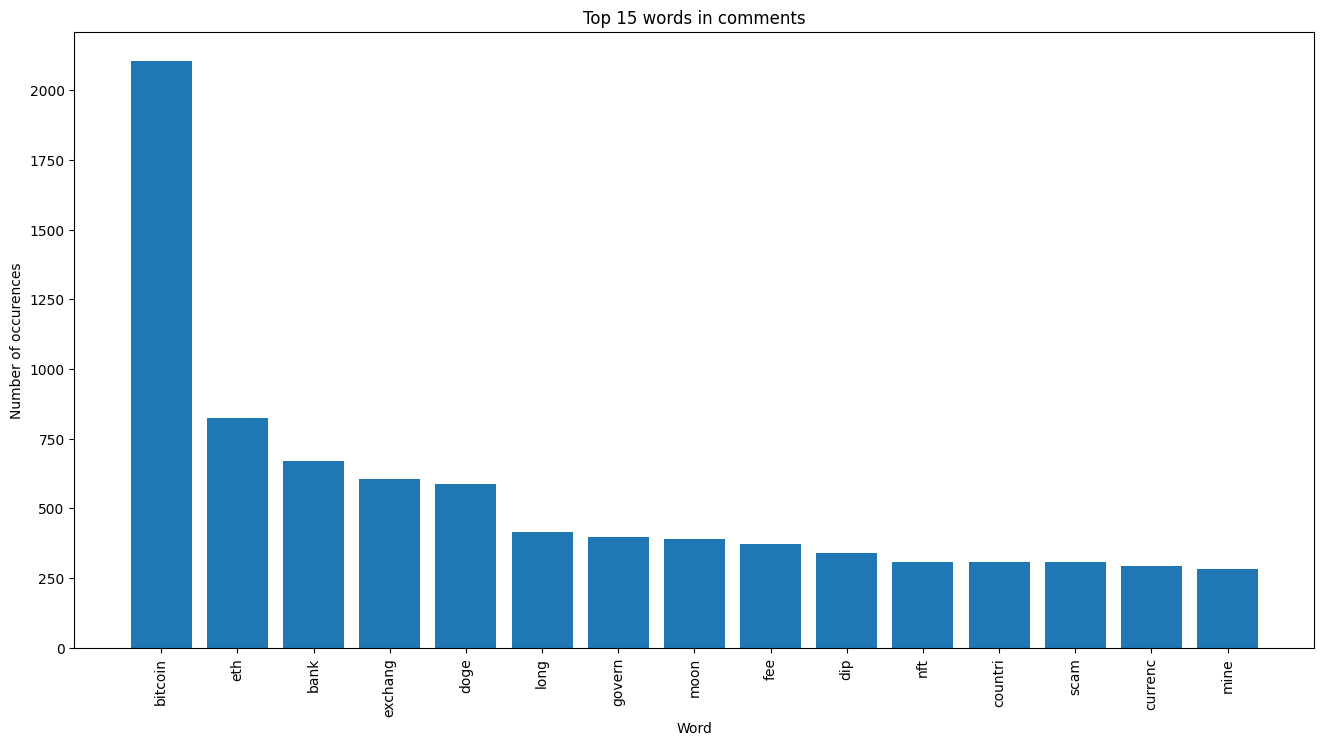

In [ ]:
words = []
word_values = []
for i,j in get_top_n_words(top_comments['cleaned_comments'], stop, 15):
    words.append(i)
    word_values.append(j)

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');
ax.set_title('Top 15 words in comments');
ax.set_xlabel('Word');
ax.set_ylabel('Number of occurences');
plt.show()

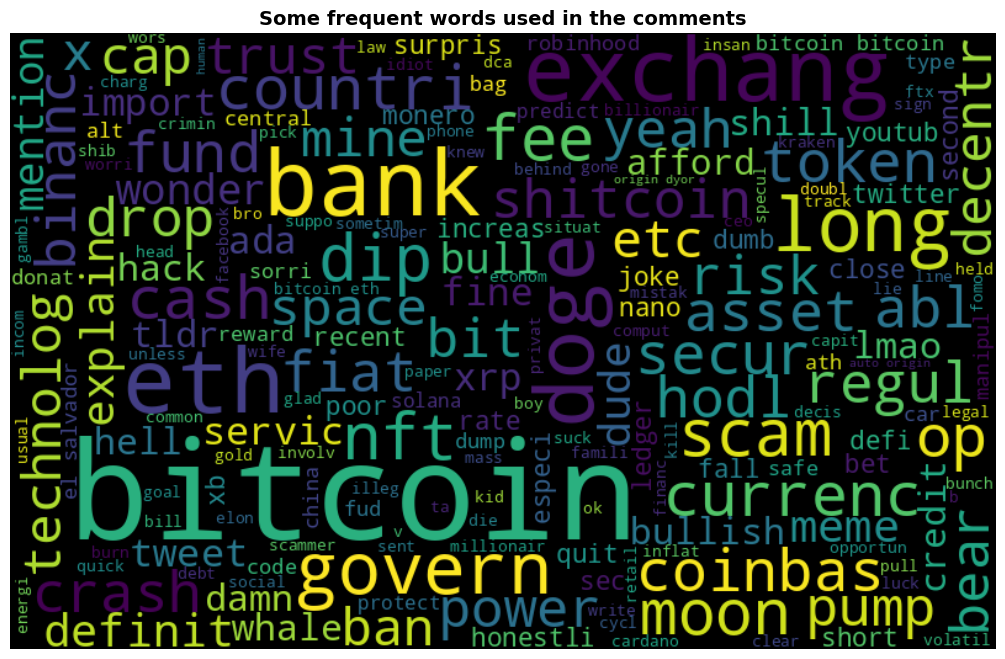

In [ ]:
all_words = ' '.join([word for word in top_comments['cleaned_comments']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)
plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title("Some frequent words used in the comments", weight='bold', fontsize=14)
plt.show()

Explore most frequent nouns, verbs, and adjectives

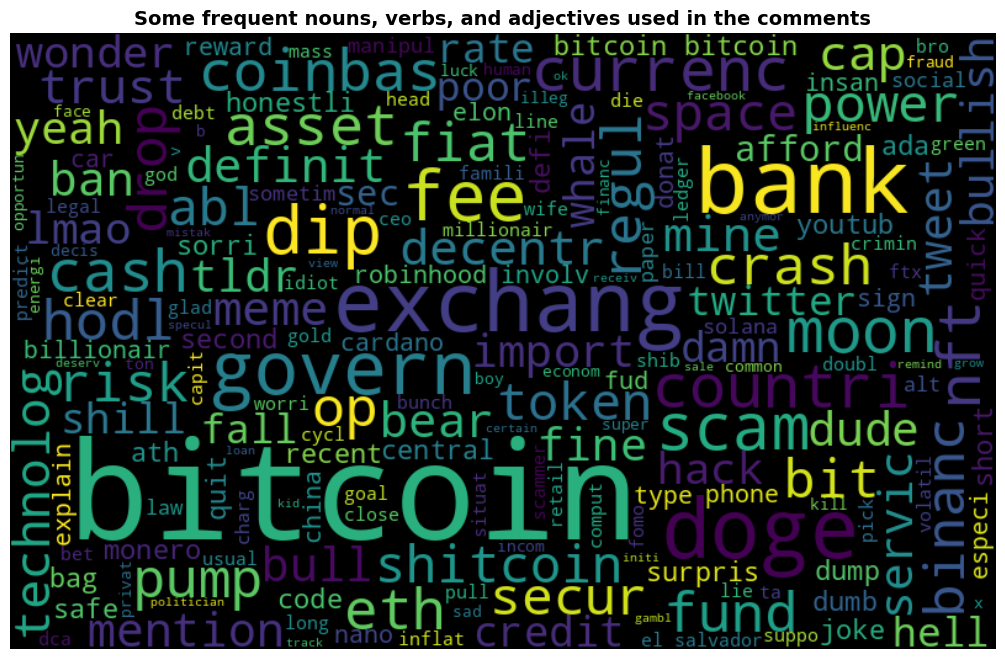

In [ ]:
all_nouns = ' '.join([word for word in top_comments['nouns_verbs_adj']])
all_nouns
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_nouns)
plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title("Some frequent nouns, verbs, and adjectives used in the comments", weight='bold', fontsize=14)
plt.show()

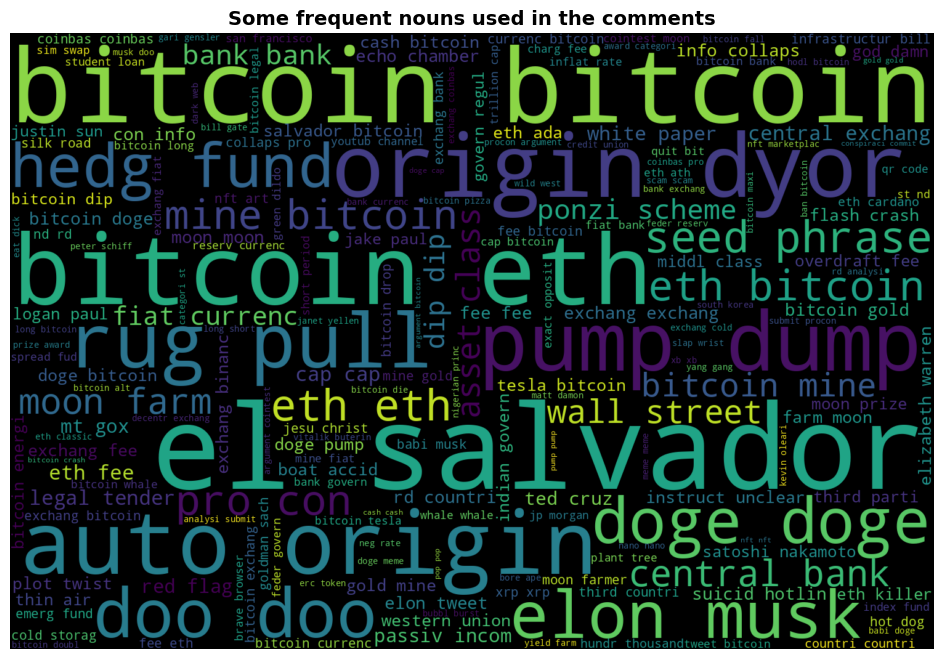

In [ ]:
#get dictionary of top bigrams and frequencies
bigrams_freq = find_top_bigrams( top_comments['cleaned_comments'])

#Generating wordcloud
WC_height = 1000
WC_width = 1500
WC_max_words = 200
wordCloud = WordCloud(max_words=WC_max_words, height=WC_height, width=WC_width)
wordCloud.generate_from_frequencies(bigrams_freq)
plt.figure(figsize=(15, 8))
plt.imshow(wordCloud, interpolation="bilinear")
plt.axis('off')
plt.title("Some frequent nouns used in the comments", weight='bold', fontsize=14)
plt.show()

# Topic Modeling

In [ ]:
comments = list(top_comments['cleaned_comments'])

topics = 9
topic_words = 10
topic_names = ['Bitcoin', 'CBDC', 'Ethereum', 'Trusts', 'Exchanges', 'Privacy', 'Ripple', 'Doge', 'Nano' ]
mindf = 5

In [ ]:
comments

### Count Vectorization

In [ ]:
cv = CountVectorizer(stop_words=stop)
X_cv = cv.fit_transform(comments)
# pd.DataFrame(X_cv.toarray(), columns=cv.get_feature_names())

#### Non-Negative Matrix Factorization (NMF) with Count Vectorization

In [ ]:
nmf_cv = NMF(topics)
X_nmf_cv = nmf_cv.fit_transform(X_cv)
# nmf_cv.explained_variance_ratio_

In [ ]:
display_topics(nmf_cv, cv.get_feature_names_out(), topic_words, topic_names)


Topic: ' Bitcoin '
bitcoin, cap, fiat, energi, el, salvador, drop, countri, tldr, origin

Topic: ' CBDC '
eth, fee, secur, power, fork, eip, po, xrp, code, dev

Topic: ' Ethereum '
doo, musk, babi, daddi, mommi, scam, surpris, contribut, elon, twitter

Topic: ' Trusts '
doge, cap, demand, increas, currenc, fiat, appli, definit, infinit, imposs

Topic: ' Exchanges '
bank, currenc, exchang, blind, regul, central, servic, credit, confirm, fee

Topic: ' Privacy '
exchang, safemoon, token, xb, ponzi, fee, scheme, evid, risk, burn

Topic: ' Ripple '
govern, nft, long, countri, secur, risk, asset, regul, technolog, currenc

Topic: ' Doge '
mine, gold, energi, us, wast, effici, thousand, power, oil, ton

Topic: ' Nano '
cardano, eth, migrat, dapp, ecosystem, token, charl, bear, xb, nft


*NMF with Count Vectorization got the most clear topics with a topic number of 9*

#### Create document topic matrix

In [ ]:
#get topic probablitity df
nmf_cv_probs = prob_df(X_nmf_cv, ['Bitcoin', 'CBDC', 'Ethereum', 'Trusts', 'Exchanges',
                                                       'Privacy', 'Ripple', 'Doge', 'Nano' ])

#add date and comments
nmf_cv_probs['date'] = top_comments['date']
nmf_cv_probs['comment'] = top_comments['comment']
nmf_cv_probs['comments_cleaned'] = top_comments['cleaned_comments']

nmf_cv_probs['topic_choice'].value_counts(normalize=True)

Ripple       0.550557
Bitcoin      0.159425
Privacy      0.091504
CBDC         0.050351
Nano         0.038559
Trusts       0.038205
Exchanges    0.035198
Doge         0.033253
Ethereum     0.002948
Name: topic_choice, dtype: float64

#### Create Word Topic Matrix

In [ ]:
word_df = topic_matrix(nmf_cv, cv.get_feature_names_out(), ['Bitcoin', 'CBDC', 'Ethereum', 'Trusts', 'Exchanges',
                                                       'Privacy', 'Ripple', 'Doge', 'Nano' ])

#save as csv
word_df.to_csv('/content/drive/MyDrive/word_topic_analysis.csv')

#### Get top words of each topic

In [ ]:
replace_words = {'energi': 'energy',
                 'servic': 'service',
                 'currenc': 'currency',
                 'decentr': 'decentralized',
                 'neg': 'negative',
                 'privat': 'private',
                 'coinbas': 'coinbase',
                 'binanc': 'binance',
                 'equiti': 'equity',
                 'charg': 'charge',
                 'secur': 'secure',
                 'technolog': 'technology',
                 'cryptographi': 'cryptography'}

top_topic_words_df = top_topics_df(nmf_cv, cv.get_feature_names_out(), 10, topic_names, replace_words)
print(top_topic_words_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 1 to 9
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Bitcoin_words     9 non-null      object 
 1   Bitcoin_values    9 non-null      float64
 2   CBDC_words        9 non-null      object 
 3   CBDC_values       9 non-null      float64
 4   Ethereum_words    9 non-null      object 
 5   Ethereum_values   9 non-null      float64
 6   Trusts_words      9 non-null      object 
 7   Trusts_values     9 non-null      float64
 8   Exchanges_words   9 non-null      object 
 9   Exchanges_values  9 non-null      float64
 10  Privacy_words     9 non-null      object 
 11  Privacy_values    9 non-null      float64
 12  Ripple_words      9 non-null      object 
 13  Ripple_values     9 non-null      float64
 14  Doge_words        9 non-null      object 
 15  Doge_values       9 non-null      float64
 16  Nano_words        9 non-null      object 
 17  N

In [ ]:
#save as csv on data folder
top_topic_words_df.to_csv('/content/drive/MyDrive/top_topic_words.csv')

## Sentiment Analysis

In [ ]:
comment_topic_sentiment_df = get_sentiments(nmf_cv_probs)

In [ ]:
comment_topic_sentiment_price_df = comment_topic_sentiment_df.copy()


#add crypto prices to comment_topic_sentiment_df
cryptos = ['BTC', 'ETH', 'XRP','NANO', 'DOGE']
for c in cryptos:
    name = c+'_price'
    comment_topic_sentiment_price_df[name] = top_comments[c]

In [ ]:
comment_topic_sentiment_price_df.head()

In [ ]:
#save as csv on data folder
comment_topic_sentiment_price_df.to_csv('/content/drive/MyDrive/topic_sentiment_analysis_comments.csv')

SENTIMENT ANALYSIS TRENDS

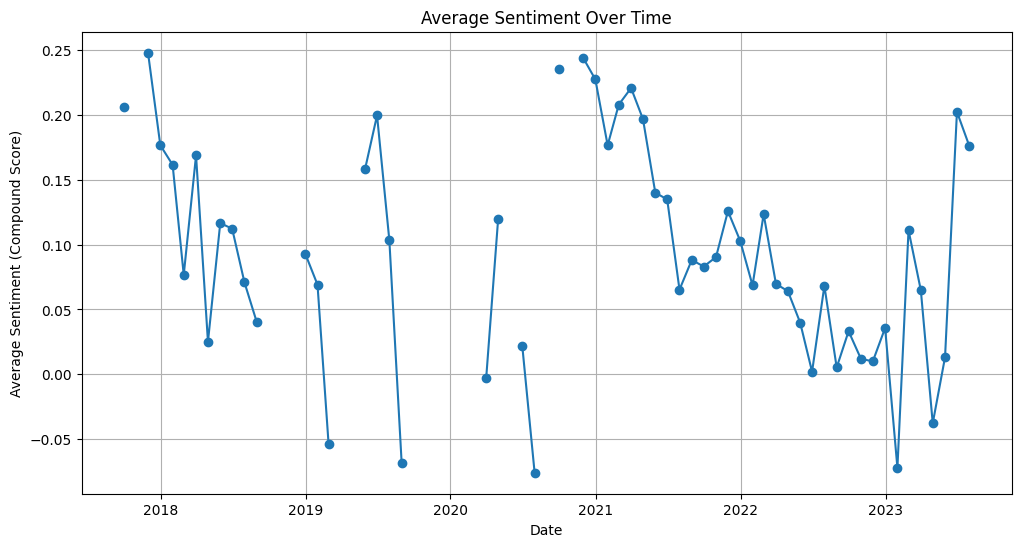

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your dataset
df = pd.read_csv('/content/drive/MyDrive/topic_sentiment_analysis_comments.csv')

# Convert the 'date' column to datetime
df['date'] = pd.to_datetime(df['date'])

# Set the date column as the index
df.set_index('date', inplace=True)

# Calculate average sentiment by month
monthly_sentiment = df.resample('M')['compound'].mean()

# Plot sentiment trends over time
plt.figure(figsize=(12, 6))
plt.plot(monthly_sentiment.index, monthly_sentiment.values, marker='o', linestyle='-')
plt.title('Average Sentiment Over Time')
plt.xlabel('Date')
plt.ylabel('Average Sentiment (Compound Score)')
plt.grid(True)
plt.show()

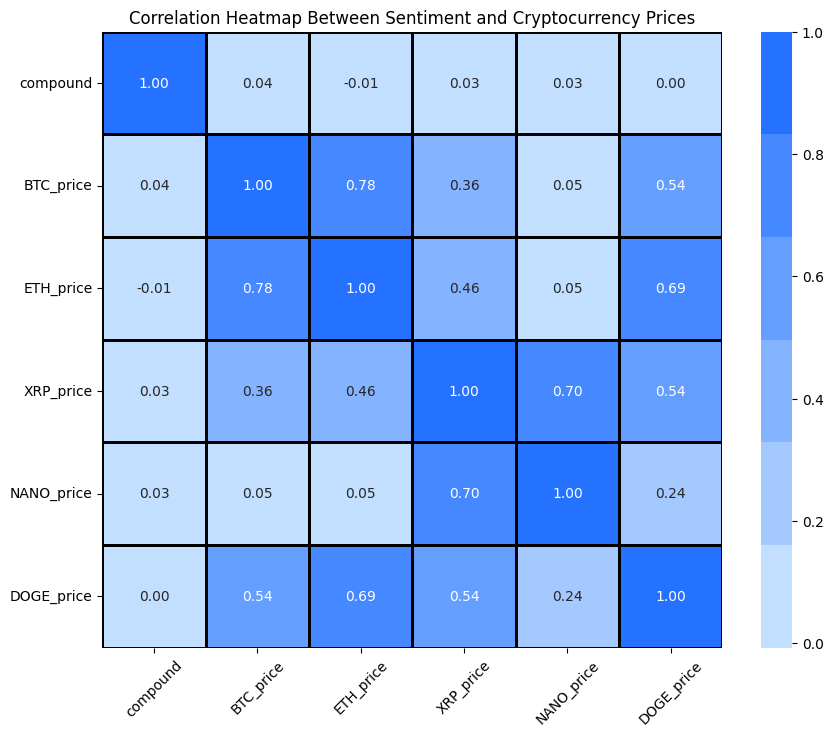

In [ ]:
import seaborn as sns
# Calculate correlations between sentiment and cryptocurrency prices
corr_matrix = df[['compound', 'BTC_price', 'ETH_price', 'XRP_price', 'NANO_price', 'DOGE_price']].corr()

# Define custom colors for the heatmap
colors = ['#c2dfff', '#a3c9ff', '#84b3ff', '#649eff', '#4588ff', '#2472ff']

# Create a heatmap with custom colors and annotations
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap=sns.color_palette(colors), fmt=".2f", linewidths=1, linecolor='black')
plt.title('Correlation Heatmap Between Sentiment and Cryptocurrency Prices')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

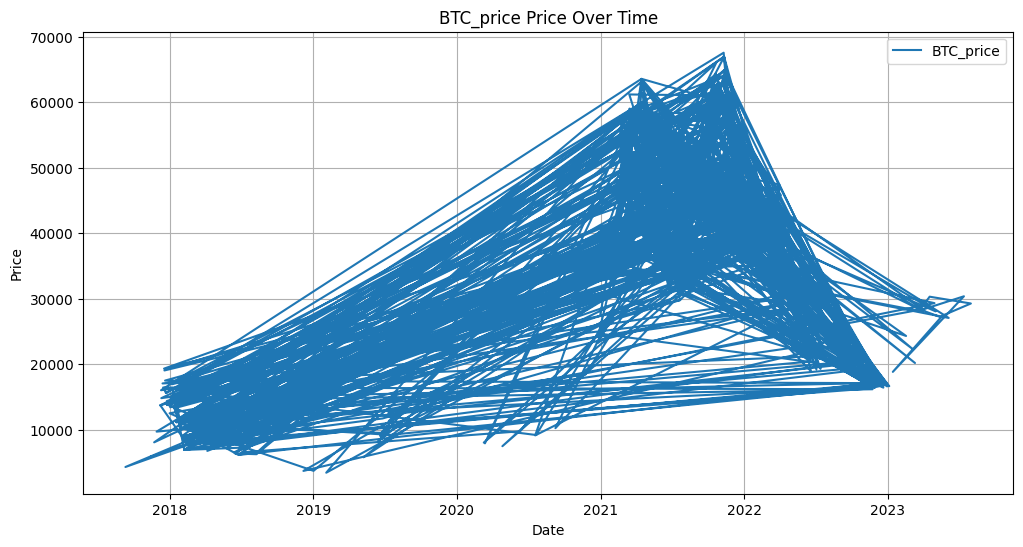

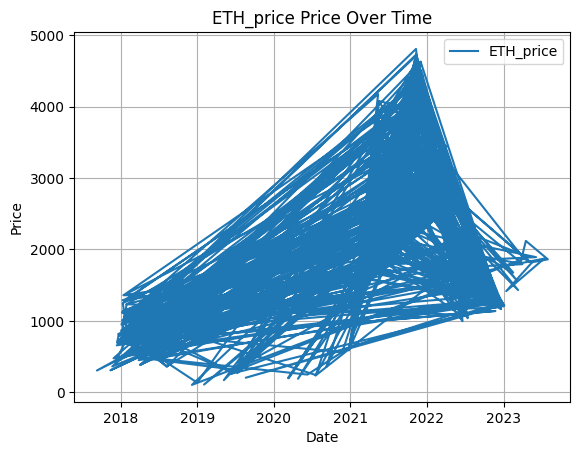

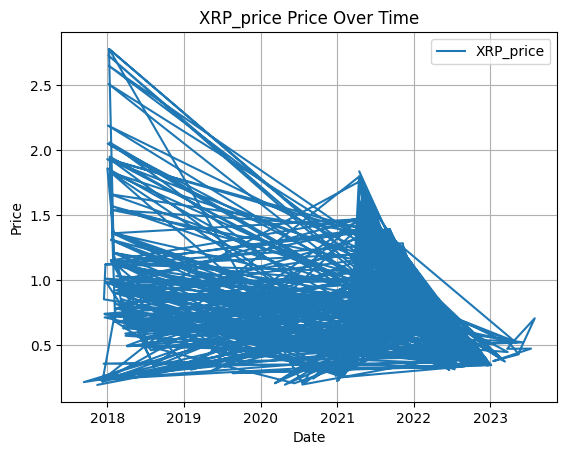

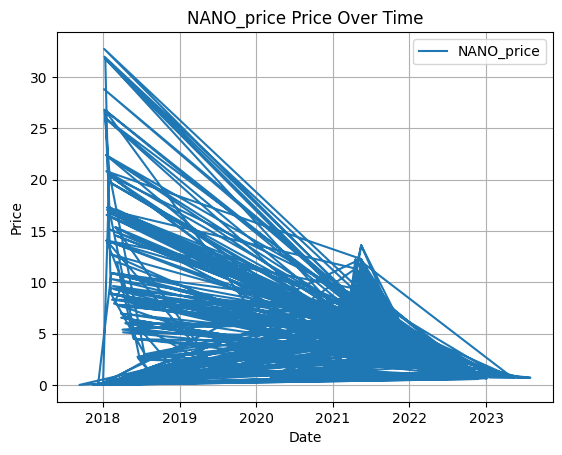

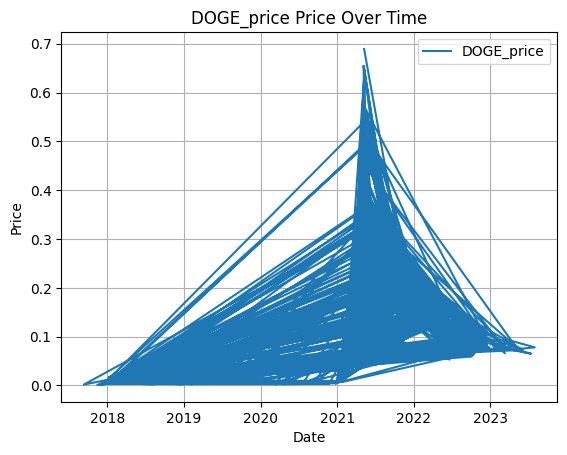

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your dataset
df = pd.read_csv('/content/drive/MyDrive/topic_sentiment_analysis_comments.csv')

# Convert the 'date' column to datetime
df['date'] = pd.to_datetime(df['date'])

# Set the date column as the index
df.set_index('date', inplace=True)

# List of cryptocurrency columns
crypto_columns = ['BTC_price', 'ETH_price', 'XRP_price', 'NANO_price', 'DOGE_price']

# Plot cryptocurrency prices over time for each cryptocurrency
plt.figure(figsize=(12, 6))

for crypto_column in crypto_columns:
    plt.plot(df.index, df[crypto_column], label=crypto_column)
    plt.title(f'{crypto_column} Price Over Time')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()


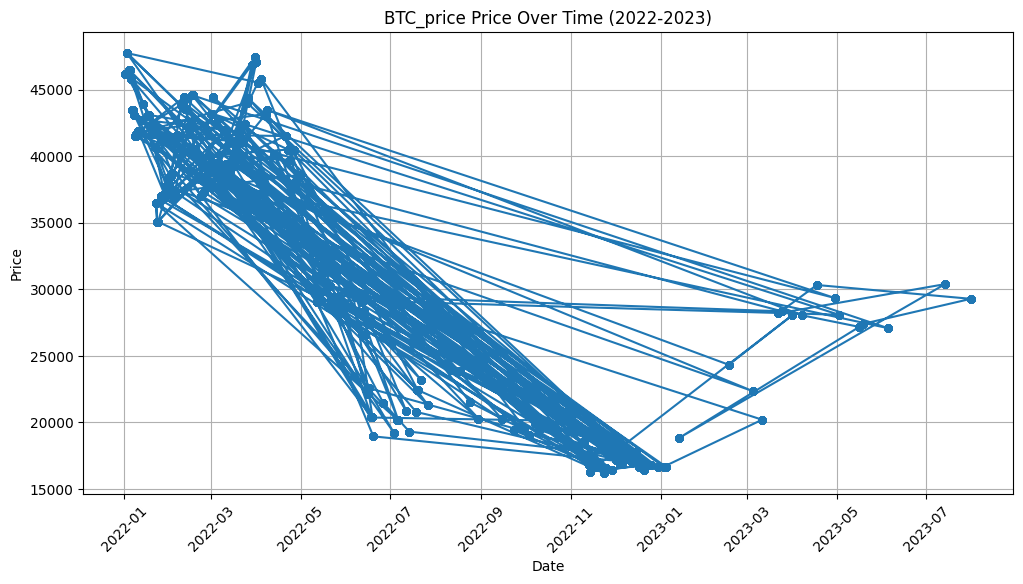

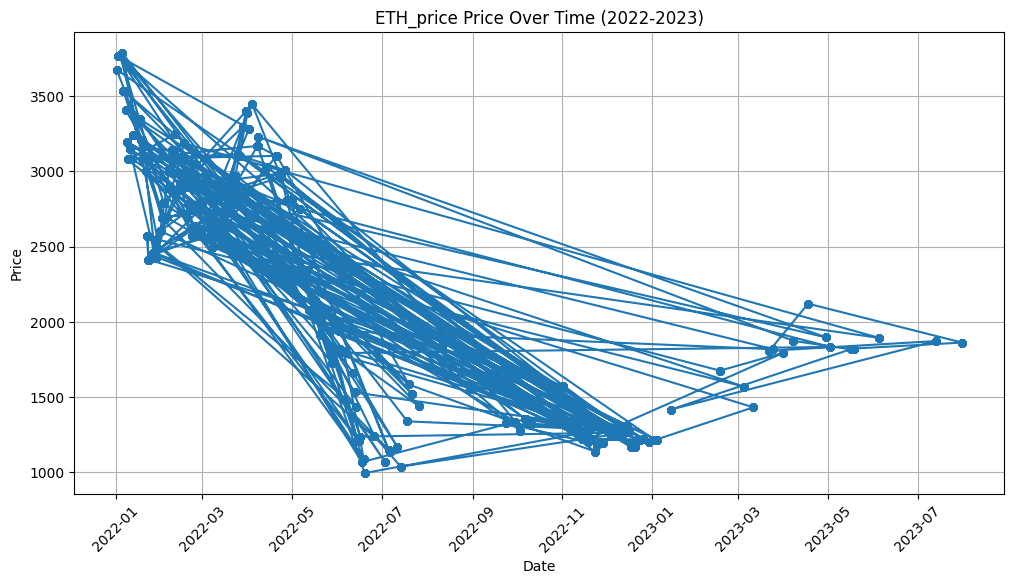

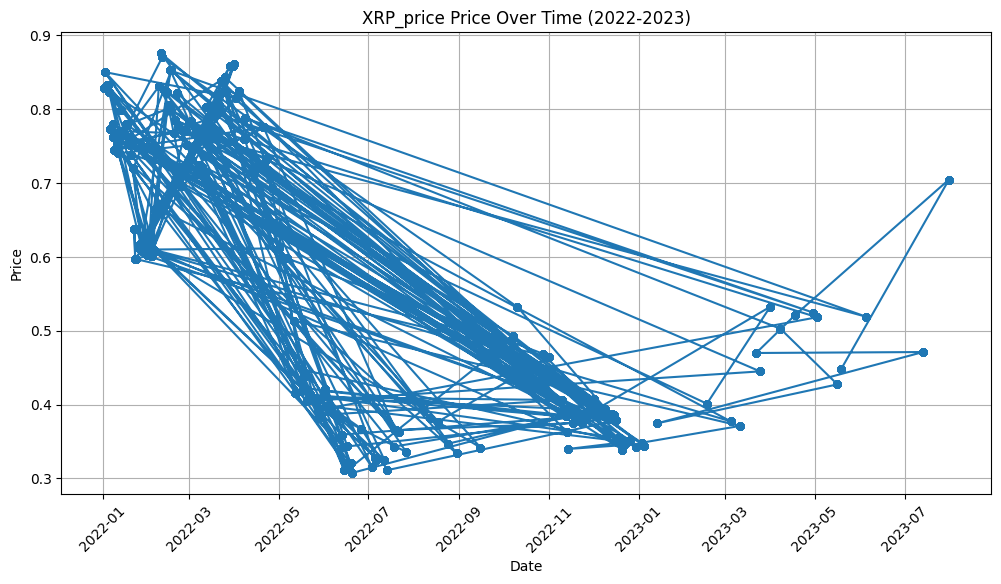

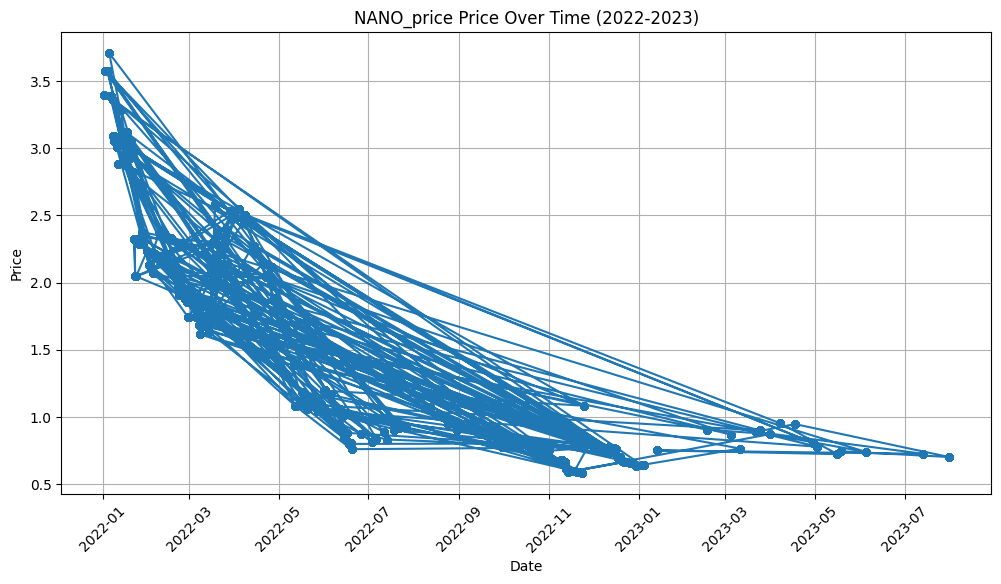

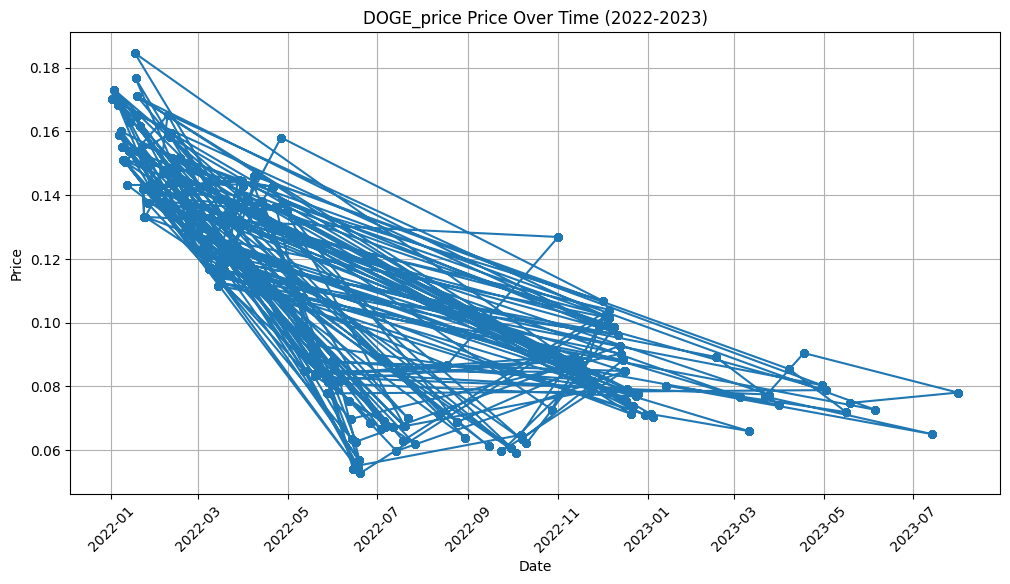

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your dataset
df = pd.read_csv('/content/drive/MyDrive/topic_sentiment_analysis_comments.csv')

# Convert the 'date' column to datetime
df['date'] = pd.to_datetime(df['date'])

# Set the date column as the index
df.set_index('date', inplace=True)

# Filter data for the year 2022-2023
start_date = '2022-01-01'
end_date = '2023-12-31'
filtered_df = df[(df.index >= start_date) & (df.index <= end_date)]

# List of cryptocurrency columns
crypto_columns = ['BTC_price', 'ETH_price', 'XRP_price', 'NANO_price', 'DOGE_price']

# Plot cryptocurrency prices month-wise for 2022-2023
for crypto_column in crypto_columns:
    plt.figure(figsize=(12, 6))
    plt.plot(filtered_df.index, filtered_df[crypto_column], marker='o', linestyle='-', markersize=5)
    plt.title(f'{crypto_column} Price Over Time (2022-2023)')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()


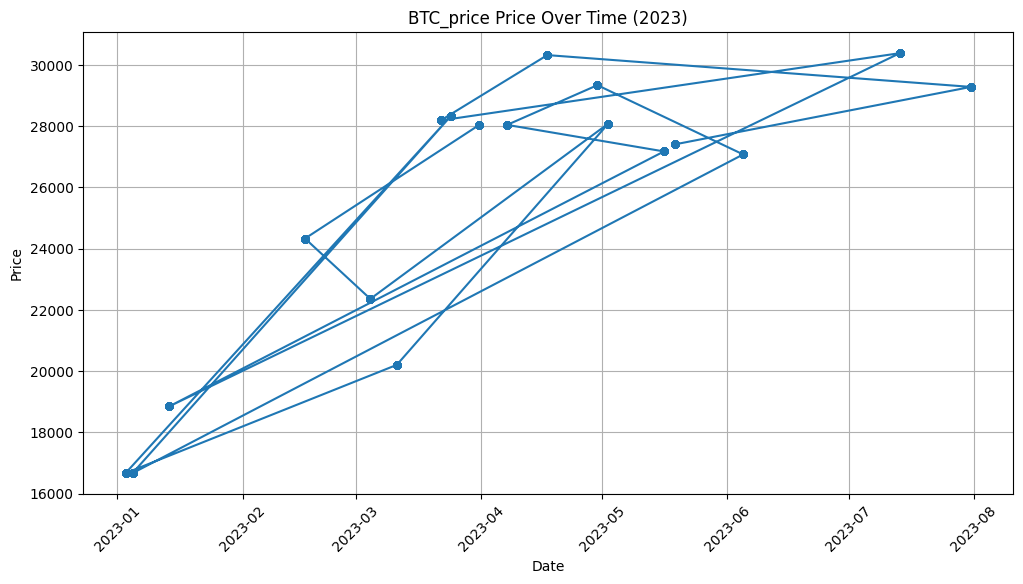

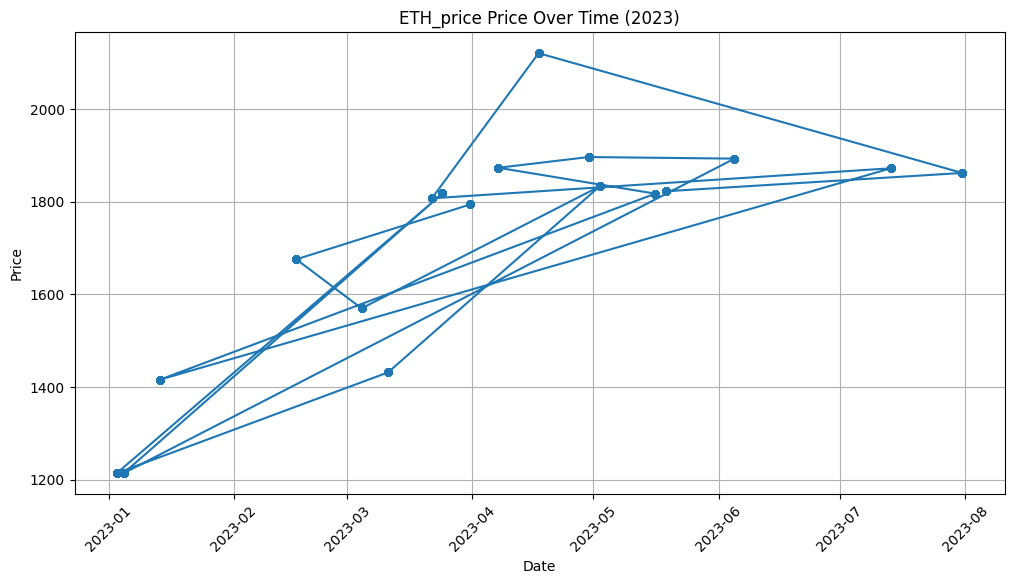

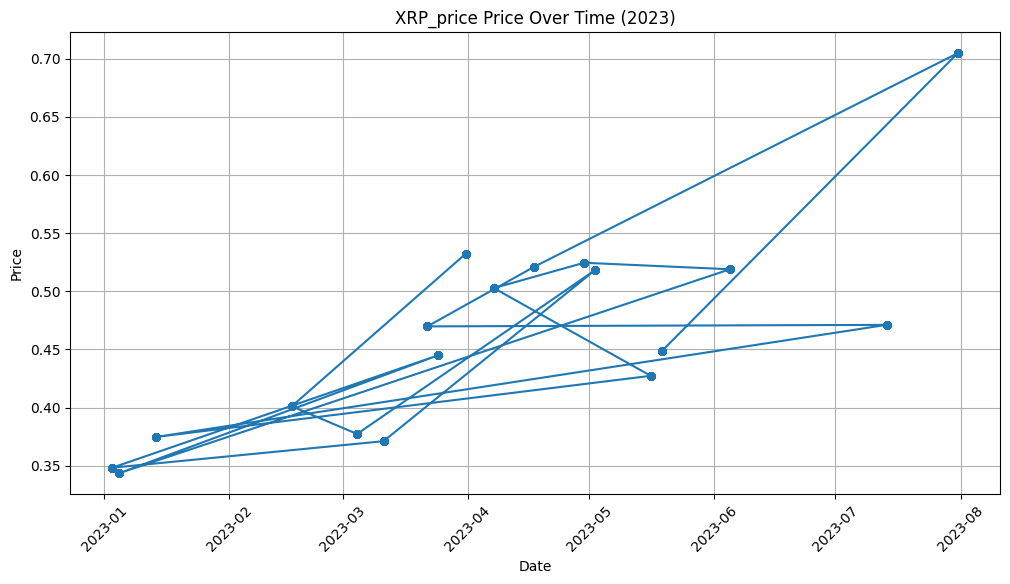

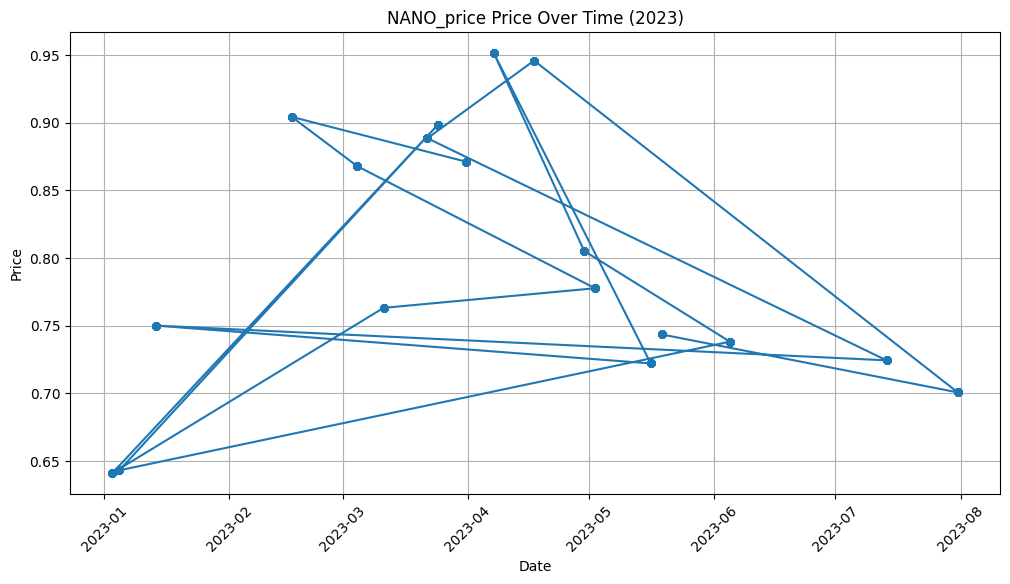

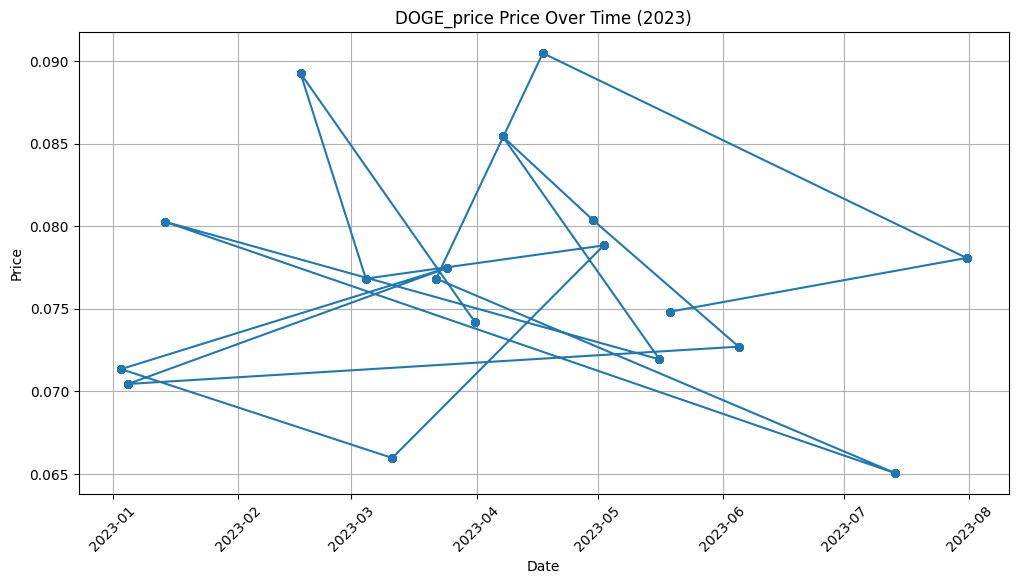

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your dataset
df = pd.read_csv('/content/drive/MyDrive/topic_sentiment_analysis_comments.csv')

# Convert the 'date' column to datetime
df['date'] = pd.to_datetime(df['date'])

# Set the date column as the index
df.set_index('date', inplace=True)

# Filter data for the year 2023
start_date = '2023-01-01'
end_date = '2023-12-31'
filtered_df = df[(df.index >= start_date) & (df.index <= end_date)]

# List of cryptocurrency columns
crypto_columns = ['BTC_price', 'ETH_price', 'XRP_price', 'NANO_price', 'DOGE_price']

# Plot cryptocurrency prices month-wise for 2023
for crypto_column in crypto_columns:
    plt.figure(figsize=(12, 6))
    plt.plot(filtered_df.index, filtered_df[crypto_column], marker='o', linestyle='-', markersize=5)
    plt.title(f'{crypto_column} Price Over Time (2023)')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()


In [4]:
import pandas as pd
df=pd.read_csv("/topic_sentiment_analysis_comments (1) (2).csv")

In [5]:
df.head()

Unnamed: 0  Bitcoin     CBDC  Ethereum   Trusts  Exchanges  Privacy  \
0           0  0.00000  0.00000   0.00000  0.12008    0.00000  0.00440   
1           1  0.00000  0.00000   0.00000  0.00000    0.00000  0.00000   
2           2  0.00004  0.00035   0.00000  0.00000    0.00000  0.00000   
3           3  0.00000  0.00000   0.00000  0.00000    0.00427  0.12465   
4           4  0.00055  0.00000   0.00001  0.00003    0.00067  0.00000   

    Ripple     Doge     Nano  ...  \
0  0.00526  0.00000  0.00000  ...   
1  0.00000  0.00000  0.00000  ...   
2  0.00174  0.00025  0.00000  ...   
3  0.00000  0.00000  0.00000  ...   
4  0.00250  0.00000  0.00575  ...   

                                    comments_cleaned  compound positive  \
0  buddi doge four five cash meanwhil poke ltc stick    0.5859    0.093   
1                                                NaN    0.4588    0.176   
2                         survivorship bia everywher   -0.1027    0.000   
3                    fomod exchang fine quick greedi    0.7144    0.166   
4                   everybodi amazon blockbust chose    0.7717    0.205   

  negative  sentiment  BTC_price  ETH_price  XRP_price NANO_price  DOGE_price  
0    0.000  posititve   57374.33    3483.96      1.582      10.01      0.6894  
1    0.000  posititve   57374.33    3483.96      1.582      10.01      0.6894  
2    0.189   negative   57374.33    3483.96      1.582      10.01      0.6894  
3    0.000  posititve   57374.33    3483.96      1.582      10.01      0.6894  
4    0.000  posititve   57374.33    3483.96      1.582      10.01      0.6894  

[5 rows x 24 columns]